In [12]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [13]:
scores_dir = Path("designed/scores")
combined_dir = Path("designed/combined")
max_round = 4
nanobodies = ["H11-D4", "Nb21", "Ty1", "VHH-72"]
score_types = ["log_likelihood_ratio", "Interface_pLDDT", "Interface_Residue_Count", "Interface_Atom_Count", "dG_separated", "weighted_score"]

sns.set_style("white")

figure_dir = Path("figures/nanobody_analysis")
figure_dir.mkdir(parents=True, exist_ok=True)

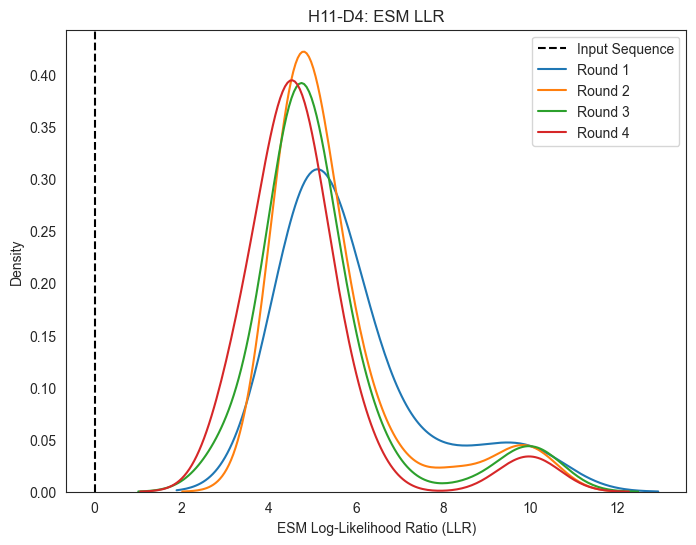

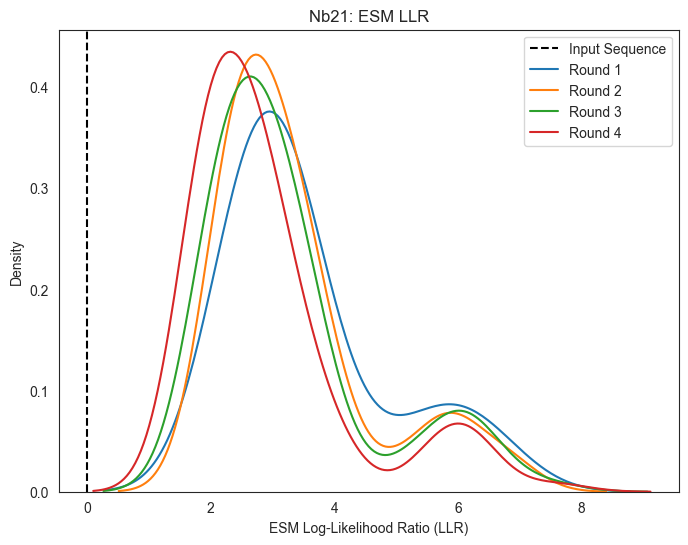

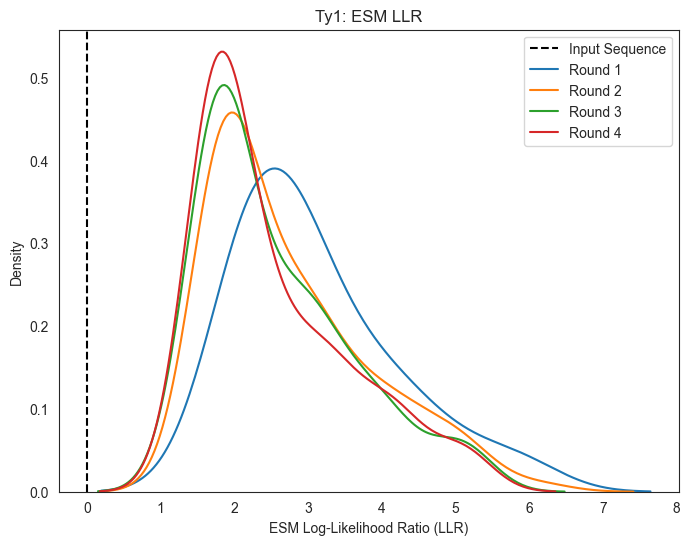

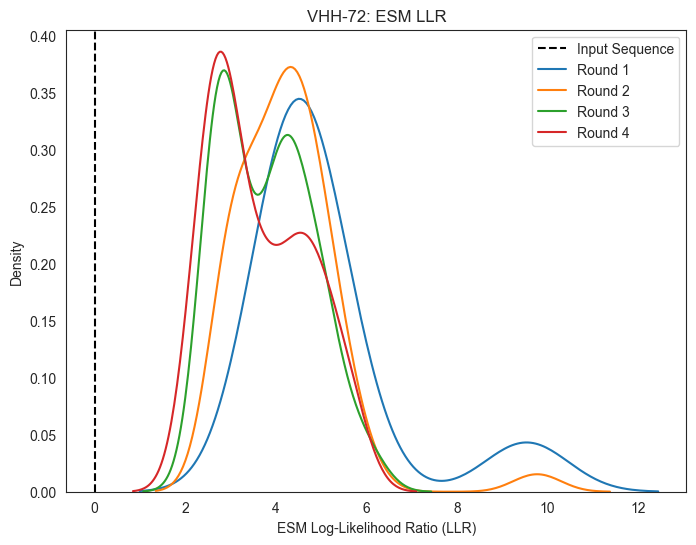

In [19]:
# Plot ESM scores across rounds (all top 20 designs per input nanobody sequence)
for nanobody in nanobodies:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.axvline(0, color="black", linestyle="--", label="Input Sequence")
    for round_num in range(1, max_round + 1):
        scores_path = scores_dir / f"round_{round_num}_scores" / f"{nanobody}_all.csv"
        scores = pd.read_csv(scores_path)
        sns.kdeplot(data=scores, x="log_likelihood_ratio", label=f"Round {round_num}", ax=ax)
    ax.set_title(f"{nanobody}: ESM LLR")
    ax.set_xlabel("ESM Log-Likelihood Ratio (LLR)")
    plt.legend()
    plt.savefig(figure_dir / f"{nanobody}_rounds_esm_llr.pdf", bbox_inches="tight")

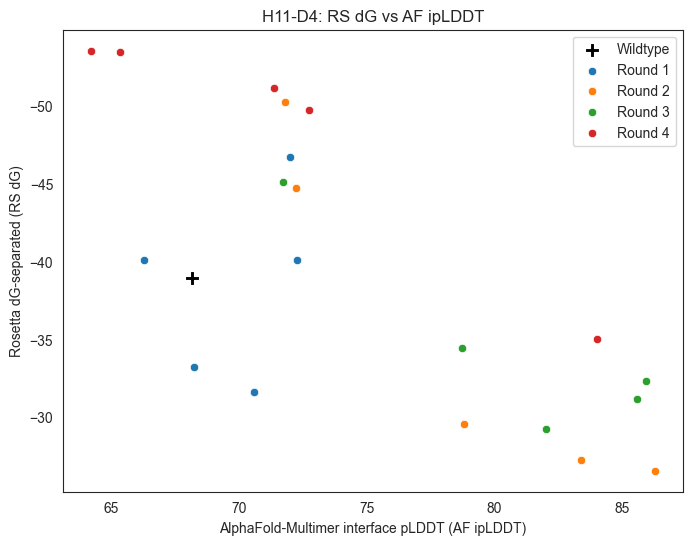

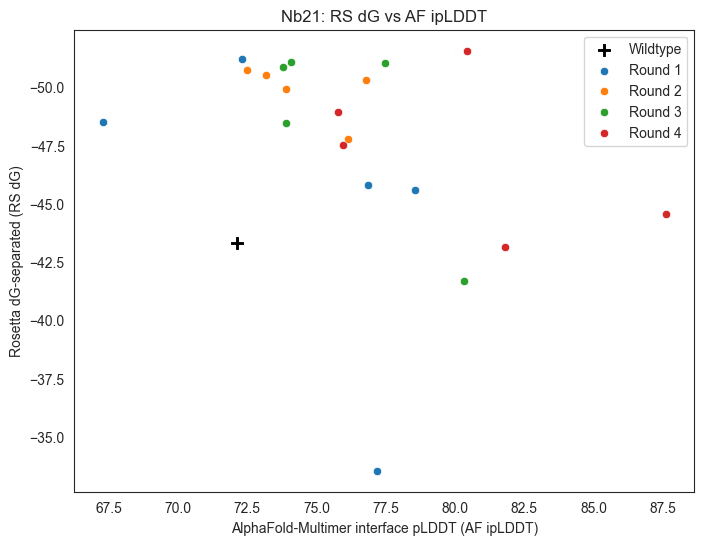

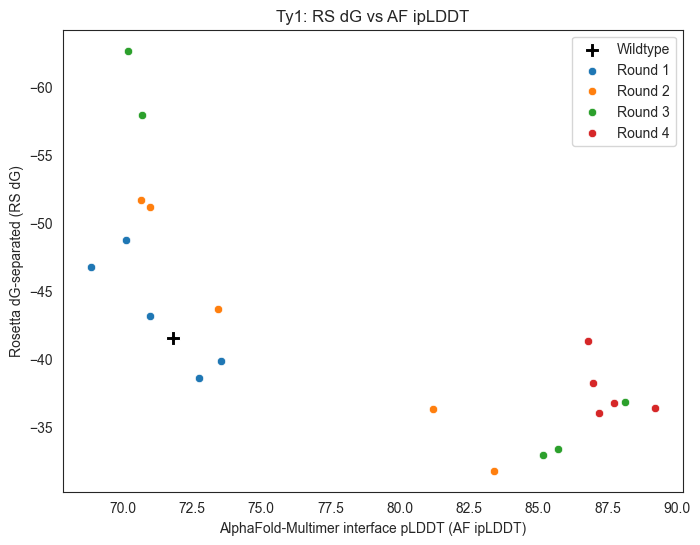

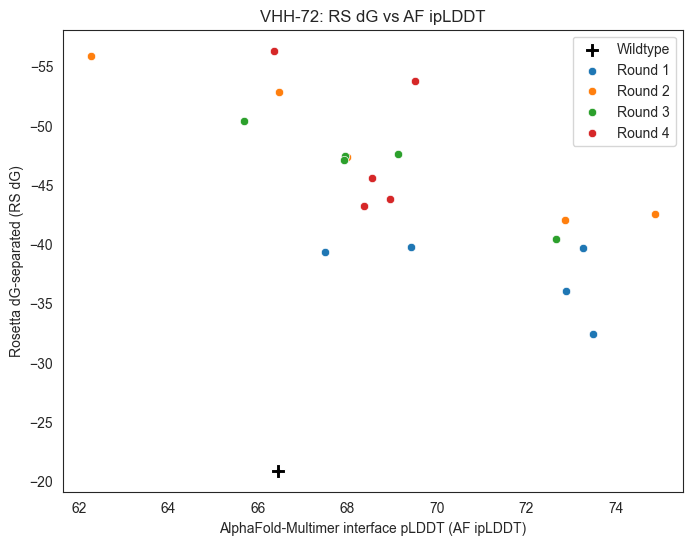

In [15]:
# Plot AlphaFold-Multimer ipLDDT vs Rosetta dG_separated scores across rounds (top 5 from each round)
for nanobody in nanobodies:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for round_num in range(max_round + 1):
        scores_path = scores_dir / f"round_{round_num}_scores" / f"{nanobody}.csv"
        scores = pd.read_csv(scores_path)
        kwargs = {"label": f"Round {round_num}"} if round_num > 0 else {"label": "Wildtype", "color": "black", "marker": "P", "s": 100, "zorder": 10}
        sns.scatterplot(data=scores, x="Interface_pLDDT", y="dG_separated", ax=ax, **kwargs)
    ax.invert_yaxis()
    ax.set_title(f"{nanobody}: RS dG vs AF ipLDDT")
    ax.set_xlabel("AlphaFold-Multimer interface pLDDT (AF ipLDDT)")
    ax.set_ylabel("Rosetta dG-separated (RS dG)")
    plt.legend()
    plt.savefig(figure_dir / f"{nanobody}_rounds_rs_dg_vs_af_iplddt.pdf", bbox_inches="tight")

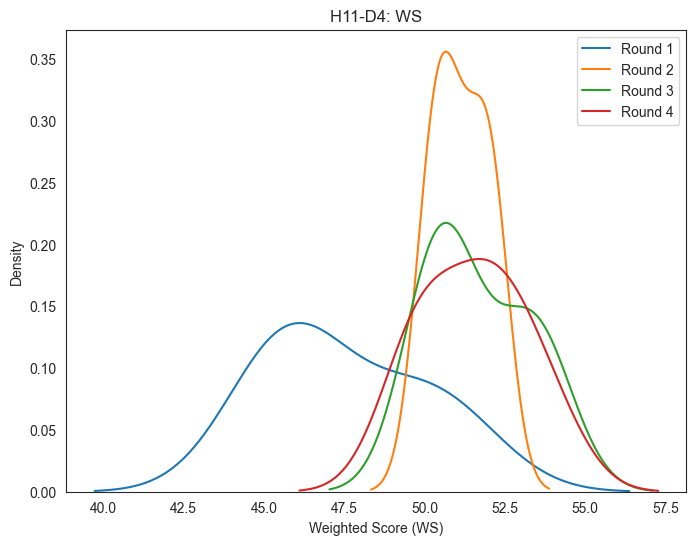

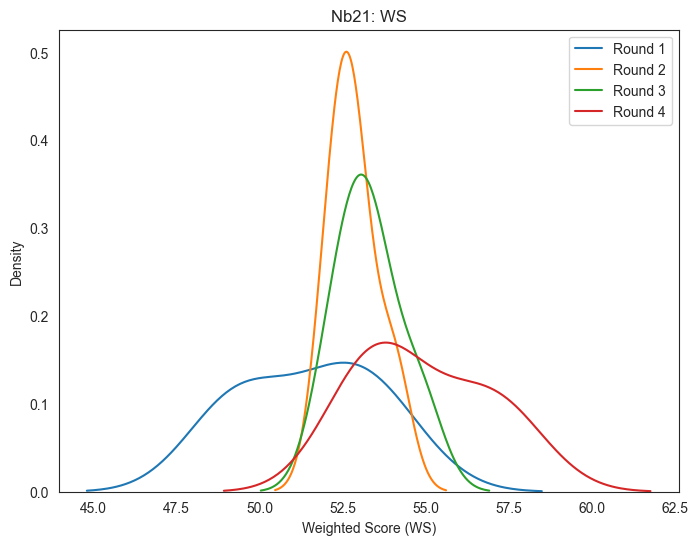

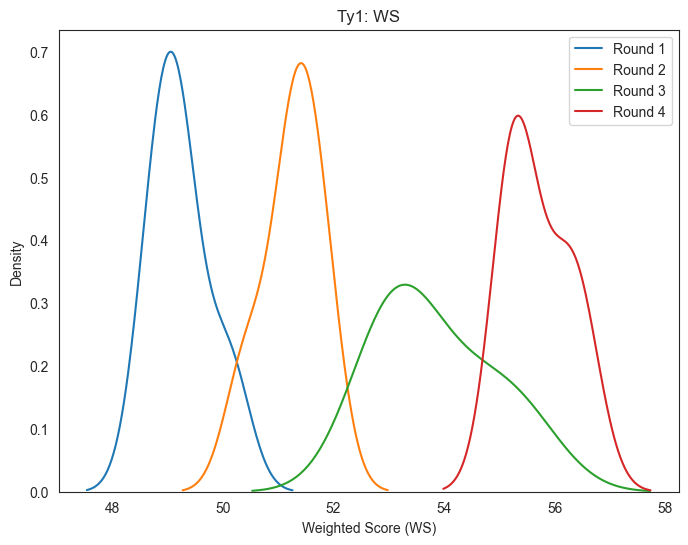

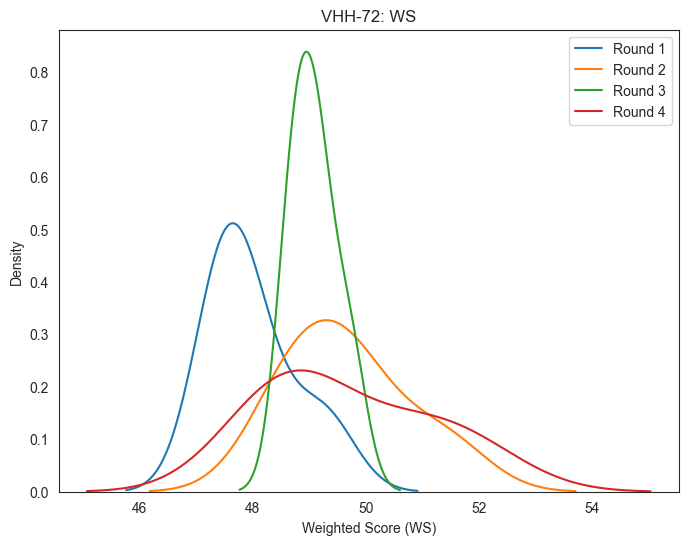

In [16]:
# Plot weighted scores of best designs across rounds
for nanobody in nanobodies:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for round_num in range(1, max_round + 1):
        scores_path = scores_dir / f"round_{round_num}_scores" / f"{nanobody}.csv"
        scores = pd.read_csv(scores_path)
        sns.kdeplot(data=scores, x="weighted_score", label=f"Round {round_num}", ax=ax)
    ax.set_title(f"{nanobody}: WS")
    ax.set_xlabel("Weighted Score (WS)")
    plt.legend()
    plt.savefig(figure_dir / f"{nanobody}_weighted_score.pdf", bbox_inches="tight")

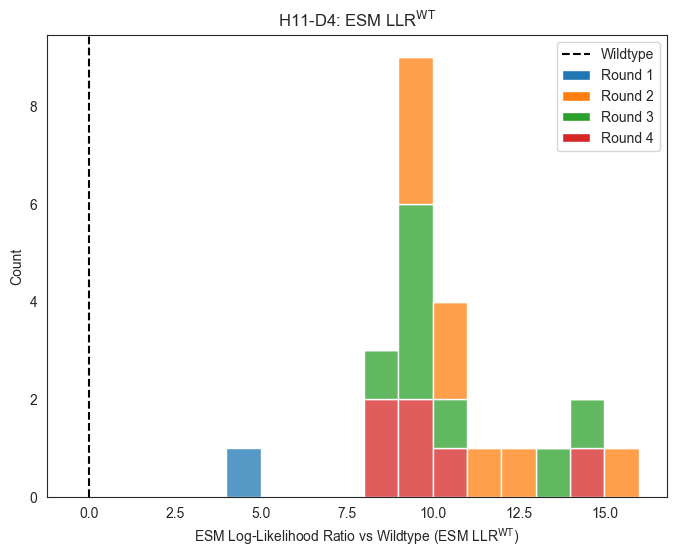

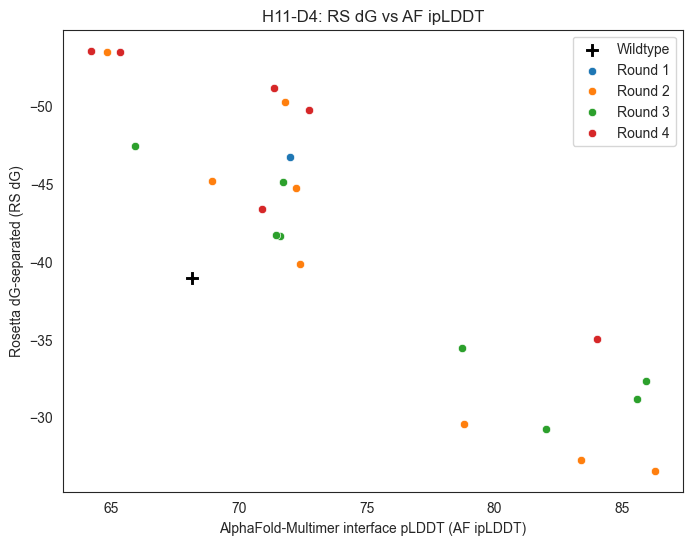

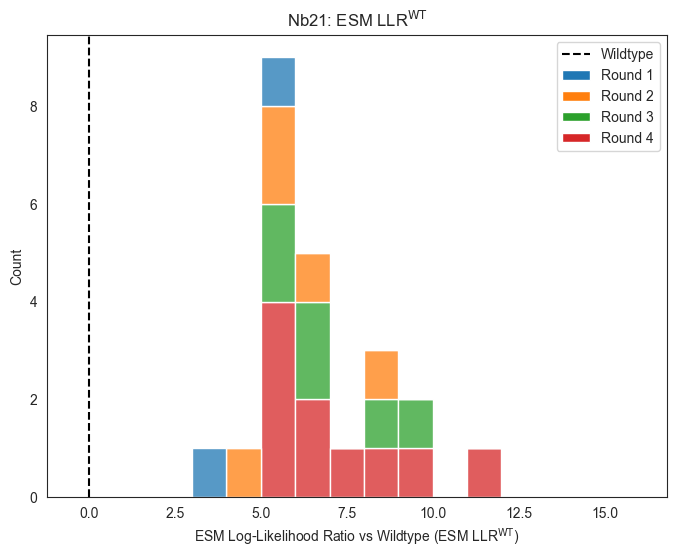

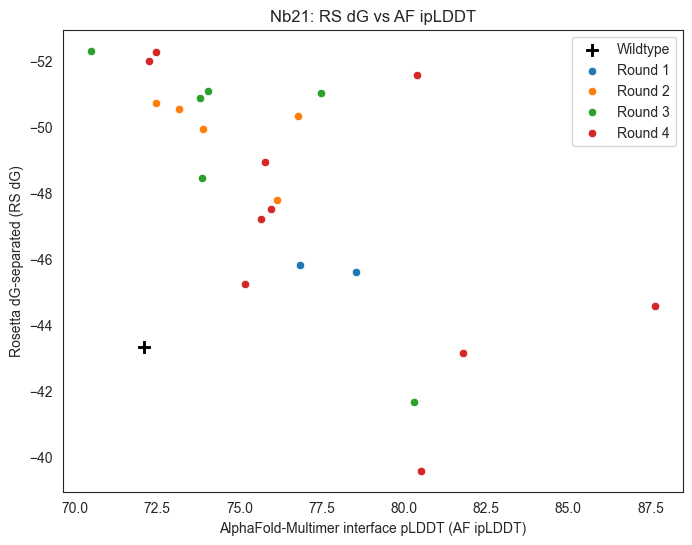

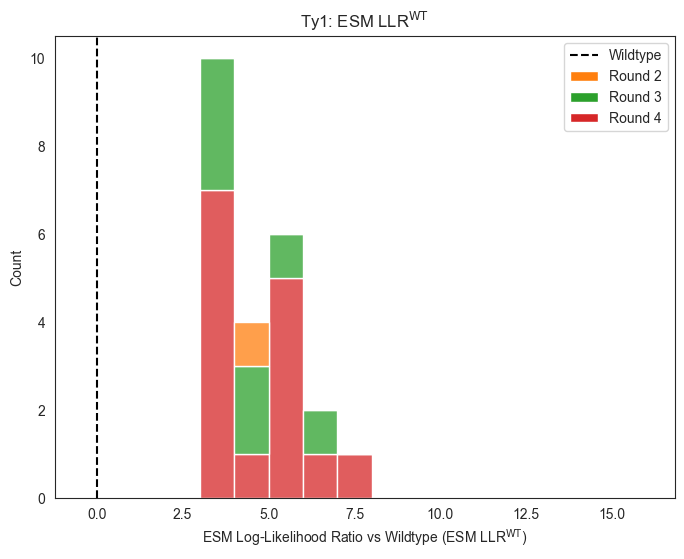

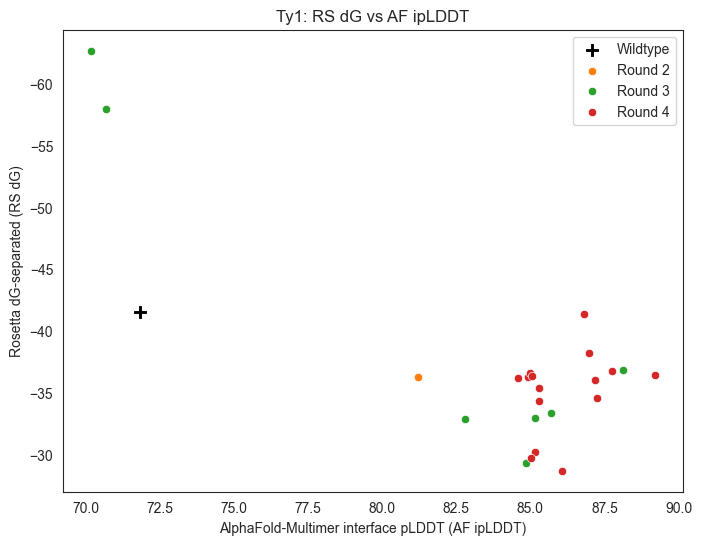

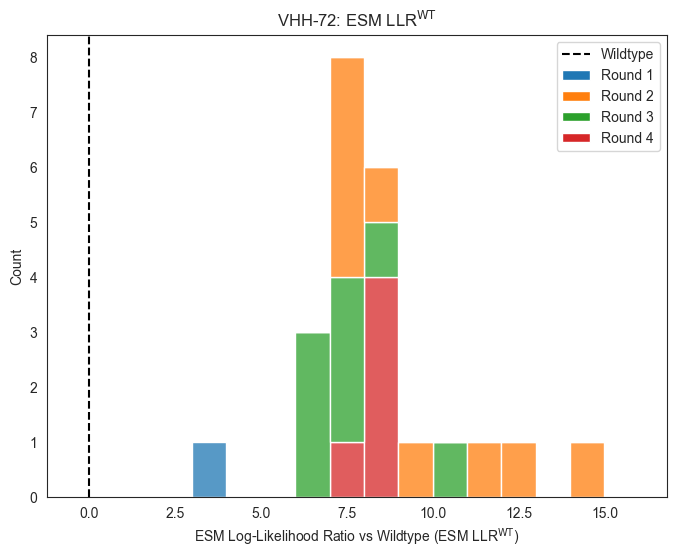

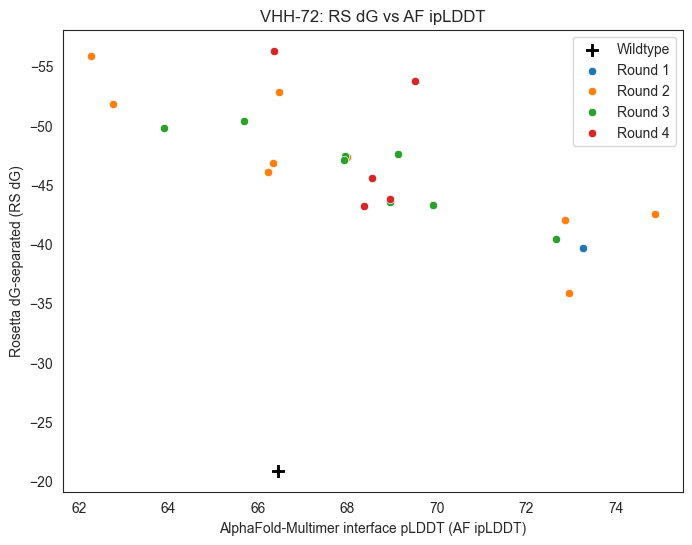

In [18]:
# Plot best designs for each nanobody
bins = np.linspace(0, 16, 17)
rounds = list(range(1, max_round + 1))
for nanobody in nanobodies:
    scores = pd.read_csv(combined_dir / f"{nanobody}.csv")
    scores["round_num"] = [len(name.replace(f"{nanobody}-", "").split("-")) for name in scores["name"]]
    designed = scores.iloc[:-1]
    wildtype = scores.iloc[-1:]

    # Plot ESM scores
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    for round_num in rounds:
        if round_num in designed["round_num"].values:
            plt.bar(0, 0, color=sns.color_palette("tab10")[round_num - 1], label=f"Round {round_num}")  # Dummy bar for legend
    sns.histplot(data=designed, x="log_likelihood_ratio_vs_wildtype", bins=bins, multiple="stack", hue="round_num", hue_order=rounds, palette="tab10", ax=ax)
    ax.axvline(wildtype.iloc[0]["log_likelihood_ratio_vs_wildtype"], color="black", linestyle="--", label="Wildtype")
    ax.set_title(f"{nanobody}: " + r"ESM LLR$^{\text{WT}}$")
    ax.set_xlabel(r"ESM Log-Likelihood Ratio vs Wildtype (ESM LLR$^{\text{WT}}$)")
    plt.legend()
    plt.savefig(figure_dir / f"{nanobody}_final_esm_llr.pdf", bbox_inches="tight")

    # Plot AlphaFold-Multimer ipLDDT vs Rosetta dG_separated scores
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.scatterplot(data=wildtype, x="Interface_pLDDT", y="dG_separated", label="Wildtype", color="black", marker="P", s=100, zorder=10)
    for round_num in range(1, max_round + 1):
        round_scores = designed[designed["round_num"] == round_num]
        sns.scatterplot(data=round_scores, x="Interface_pLDDT", y="dG_separated", label=f"Round {round_num}", ax=ax)
    ax.invert_yaxis()
    ax.set_title(f"{nanobody}: RS dG vs AF ipLDDT")
    ax.set_xlabel("AlphaFold-Multimer interface pLDDT (AF ipLDDT)")
    ax.set_ylabel("Rosetta dG-separated (RS dG)")
    plt.legend()
    plt.savefig(figure_dir / f"{nanobody}_final_rs_dg_vs_af_iplddt.pdf", bbox_inches="tight")